# 목적
* 텐서플로우 2를 이용하여 Grad-CAM 구현 과정을 하나씩 뜯어보자.

In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import urllib3
urllib3.disable_warnings()
import cv2

%matplotlib inline

In [2]:
print(tf.__version__)
print(tfds.__version__)

2.2.0
3.1.0


## 상수

In [3]:
EPOCHS = 15
BATCH_SIZE = 2**7

## 데이터 준비
* imagenet 데이터 중에서 제일 분류 잘 되는 데이터 일부를 가져다 쓰자.

In [4]:
ds = tfds.load('imagenette/160px-v2')

In [5]:
X_train, y_train = [], []
for x in ds['train']:
    img = np.array(Image.fromarray(x['image'].numpy()).resize((160,160)))
    X_train.append(img)
    y_train.append(x['label'])
    
X_test, y_test = [], []
for x in ds['validation']:
    img = np.array(Image.fromarray(x['image'].numpy()).resize((160,160)))
    X_test.append(img)
    y_test.append(x['label'])
    
X_train = np.array(X_train) / 255.
y_train = np.array(y_train)

X_test = np.array(X_test) / 255.
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9469, 160, 160, 3) (9469,)
(3925, 160, 160, 3) (3925,)


* 데이터 함 그려보자.

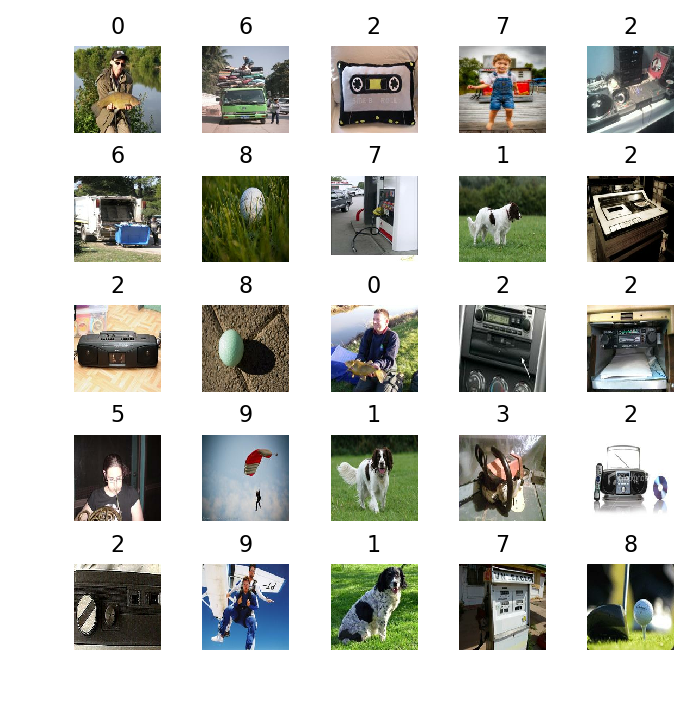

In [116]:
np.random.seed(0)
nrows, ncols = 5, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(5,5), dpi=160)
for i in range(nrows):
    for j in range(ncols):
        idx = np.random.randint(X_train.shape[0])
        ax[i][j].imshow(X_train[idx])
        ax[i][j].set_title(str(y_train[idx]), fontsize=10)
        ax[i][j].axis('off')
plt.subplots_adjust(hspace=.5)
plt.show()

In [7]:
train_dataset = tf.data.Dataset.\
            from_tensor_slices((X_train, y_train)).\
            shuffle(True).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.\
            from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

## 모델 불러오기

In [8]:
from tensorflow.keras import models, layers, losses, optimizers, metrics

In [9]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(160,160,3), include_top=False, weights='imagenet')

class Model(models.Model):
    def __init__(self,base_model):
        super(Model,self).__init__()
        self.base_model = base_model
        self.top_layer = models.Sequential([
            layers.Dense(10),
            layers.Activation(tf.nn.softmax),
        ])
        
    def call(self,inputs,training=False):
        x = self.base_model(inputs, training=training)
        x = layers.Flatten()(x)
        outputs = self.top_layer(x, training=training)
        return outputs
        
model = Model(mobilenetv2)
model.build((None, 160, 160, 3))

* 사전 학습 된거 좀만 더 트레이닝

In [10]:
opt = optimizers.Adam(learning_rate=1e-4)
scc = losses.SparseCategoricalCrossentropy()
metric = metrics.SparseCategoricalAccuracy()
loss = metrics.Mean()
acc = metrics.Mean()

In [13]:
%%time
for e in range(EPOCHS):
    start = time.time()
    for inputs in train_dataset:
        _x, _y = inputs
        with tf.GradientTape() as t:
            _y_pred = model(_x)
            _loss = scc(_y, _y_pred)
        grads = t.gradient(_loss, model.trainable_variables)
        opt.apply_gradients(list(zip(grads, model.trainable_variables)))
        loss.update_state(_loss)
        acc.update_state(metric(_y, _y_pred))
    print(f"{e+1}/{EPOCHS} loss:{loss.result():.8f} acc:{acc.result()*100:.2f}% {time.time()-start:.2f} sec/epoch")
    loss.reset_states()
    acc.reset_states()

1/5 loss:0.02328677 acc:98.17% 25.25 sec/epoch
2/5 loss:0.00937472 acc:98.28% 25.23 sec/epoch
3/5 loss:0.00960150 acc:98.39% 25.24 sec/epoch
4/5 loss:0.00660137 acc:98.49% 25.13 sec/epoch
5/5 loss:0.01162364 acc:98.57% 25.49 sec/epoch
CPU times: user 1min 2s, sys: 19 s, total: 1min 20s
Wall time: 2min 6s


## 모델 성능 확인

In [14]:
acc.reset_states()

for inputs in test_dataset:
    _x, _y = inputs
    _y_pred = model(_x)
    acc.update_state(metric(_y, _y_pred))
    
print(f"{acc.result()*100:.2f}%")

98.57%


## Grad-CAM
### Notation
* $y^c$: $c$번째 ```logit``` 값
* $A_{ij}^k$: 관찰하려는 ```layer```를 통과한 뉴런에 대응하는 값. 이 때, $i,j$는 뉴런 위치, $k$는 필터 번호
* $a_k^c$: neuron importance
$$
a_k^c = {1\over Z} \sum_{i,j} {\partial y^c \over \partial A_{i,j}^k}
$$
* Grad-CAM 최종 수식
$$
M_c(i, j) = \mbox{ReLU}\Big( \sum_k a_k^c A^k_{ij} \Big)
$$

* 위 수식을 그대로 구현만 하면 된다.
* GradientTape()를 써서 차근 차근 수식을 구현해보자.

$$
a_k^c = {1\over Z} \sum_{i,j} {\partial y^c \over \partial A_{i,j}^k}
$$

먼저 neuron importance $a_k^c$를 구하기 위해서 $c$ 에 해당하는 값을 정해준다. 이 예제에서 쓰는 이미지는 클래스 2가 정답이고, 2로 예측하므로 $c=2$를 준다.

In [55]:
image = X_train[:1]
c = 2

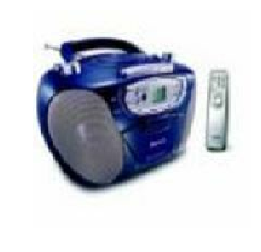

In [57]:
plt.imshow(np.squeeze(image))
plt.axis('off')
plt.show()

$y$와 $A$를 각각 구하고

In [55]:
with tf.GradientTape() as t:
    _A = model.layers[0](image)
    print('A', _A.shape)
    x = layers.Flatten()(_A)
    _y = model.layers[1].layers[0](x)[0][c]
    print('y', _y.shape)

${\partial y^c \over \partial A_{i,j}^k}$ 를 구한다. 이 때, GradientTape을 써서 아래와 같이 구한다.

In [55]:
dy_dA = t.gradient(_y, _A)

그 다음 $\sum$은 아래와 같이 np를 사용해서 구한다. 한편 $Z$는 로짓 합이 아닌가?

In [58]:
a = np.sum(np.sum(np.squeeze(dy_dA.numpy()), axis=0), axis=0) / np.sum(_y)
a.shape

(1280,)

그러면 nuron importance $a$는 구했으니, 이를 필터별 weight로 생각해서 더해주고, 0 이상의 값만 필터 axis로 더해주면 된다.
$$
M_c(i, j) = \mbox{ReLU}\Big( \sum_k a_k^c A^k_{ij} \Big)
$$

(5, 5)


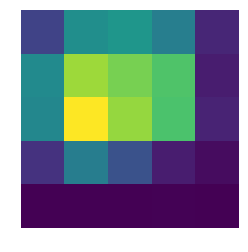

In [73]:
A = np.squeeze(_A)
M = np.maximum(0, np.sum(np.multiply(A, a), axis=-1))

plt.imshow(M)
plt.axis('off')
plt.show()

## 시각화

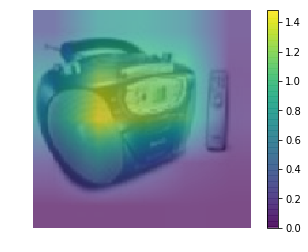

In [90]:
M_ = cv2.resize(M, (160, 160))
plt.imshow(np.squeeze(image))
plt.imshow(M_, alpha=.7)
plt.axis('off')
plt.colorbar()
plt.show()

## Grad CAM 취합

In [97]:
def get_gradcam(image, c, model=model):
    with tf.GradientTape() as t:
        _A = model.layers[0](image)
        x = layers.Flatten()(_A)
        _y = model.layers[1].layers[0](x)[0][c]
        
    dy_dA = t.gradient(_y, _A)
    a = np.sum(np.sum(np.squeeze(dy_dA.numpy()), axis=0), axis=0) / np.sum(_y)
    A = np.squeeze(_A)
    M = np.maximum(0, np.sum(np.multiply(A, a), axis=-1))
    return cv2.resize(M, np.squeeze(image).shape[:2])

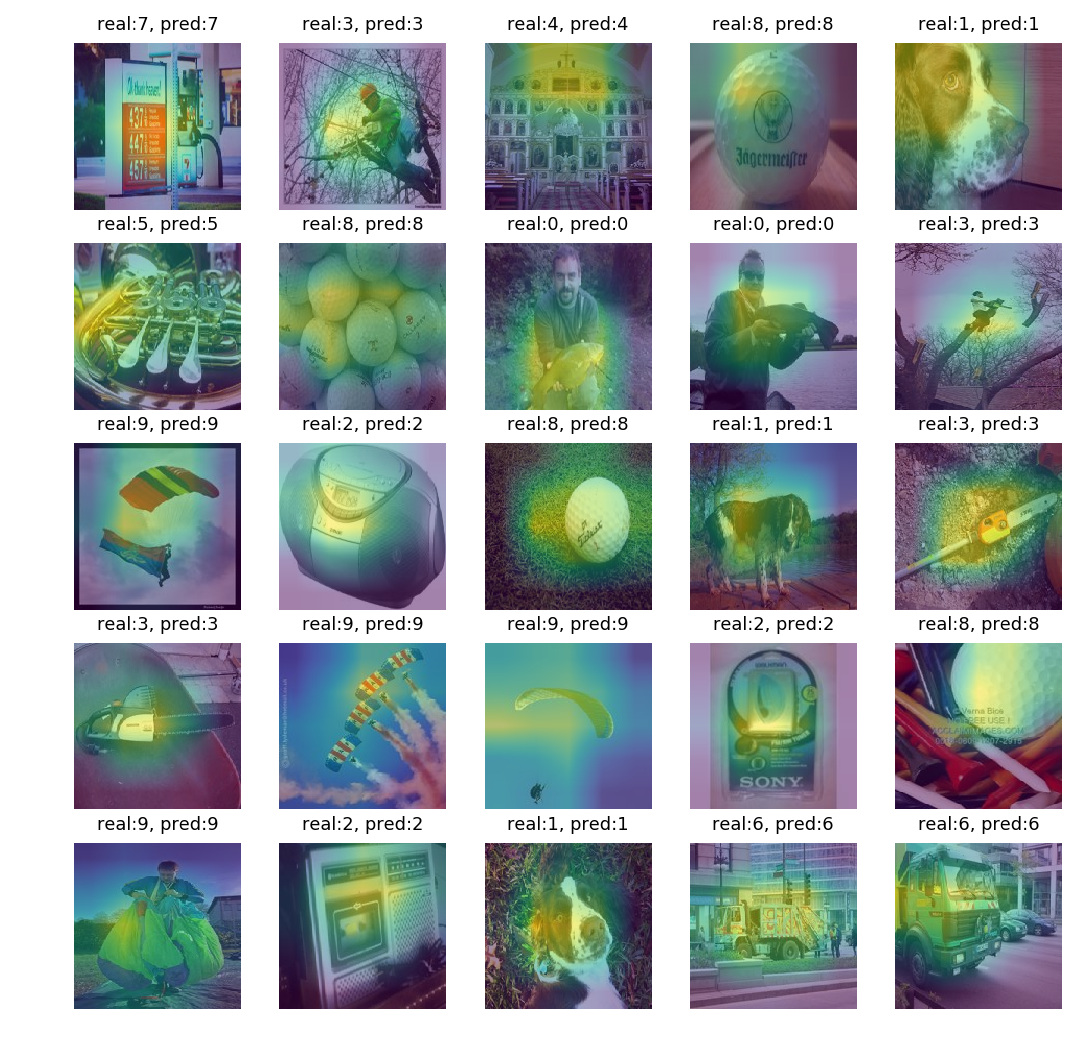

In [117]:
np.random.seed(0)
nrows = 5; ncols = 5
fig, ax = plt.subplots(nrows, ncols, figsize=(8, 8), dpi=160)
for i in range(nrows):
    for j in range(ncols):
        idx = np.random.randint(X_test.shape[0])
        image = X_test[idx:idx+1]
        c = y_test[idx]
        gradcam = get_gradcam(image, c)
        ax[i][j].imshow(np.squeeze(image))
        ax[i][j].imshow(gradcam, alpha=.5)
        ax[i][j].axis('off')
        ax[i][j].set_title(f"real:{c}, pred:{np.argmax(model(image))}", fontsize=8)
plt.show()